In [161]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [162]:
resize_to = (28, 28)

data = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset\\"):
    sub_folder_path = os.path.join("dataset\\", sub_folder)
    sub_folder_files = os.listdir(sub_folder_path)

    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join(sub_folder_path, filename)
        img = cv.imread(img_path)

        if img is None:
            print(f"Gagal membaca: {img_path}")
            continue

        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = cv.resize(img, resize_to) 

        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)

data = np.array(data)
labels = np.array(labels)


## Data Augmentation

### Define Augmentation Function


In [163]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data)):
	pass

In [164]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  295
Data setelah augmentasi:  0


## Data Preparation

### Define Preprocessing Function


In [165]:
def equalize(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    height, width = image.shape
    total_pixels = height * width
    
    histogram = [0] * 256
    for i in range(height):
        for j in range(width):
            intensity = image[i, j]
            histogram[intensity] += 1

    cdf = [0] * 256
    cdf[0] = histogram[0]
    for i in range(1, 256):
        cdf[i] = cdf[i-1] + histogram[i]

    cdf_min = min([x for x in cdf if x > 0])

    denominator = (total_pixels - cdf_min)
    if denominator == 0:
        cdf_normalized = [0] * 256 
    else:
        cdf_normalized = [(cdf[i] - cdf_min) * 255 // denominator for i in range(256)]

    equalized_image = np.zeros_like(image, dtype=np.uint8) 
    for i in range(height):
        for j in range(width):
            old_value = image[i, j]
            new_value = cdf_normalized[old_value]
            equalized_image[i, j] = new_value

    return equalized_image

def threshold(image, t):
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] >= t:
                image[i][j] = 255
            else: 
                image[i][j] = 0
    return image 

def dilasi(image, kernel_size=(3, 3)):

    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel_size

    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    padded_img = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='edge')
    result = np.zeros_like(image, dtype=np.uint8)

    for i in range(img_height):
        for j in range(img_width):
            window = padded_img[i:i+kernel_height, j:j+kernel_width]
            result[i, j] = np.max(window) 
            
    return result

def erosi(image, kernel_size=(3, 3)):
    if len(image.shape) == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) 

    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel_size

    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    padded_img = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='edge')
    result = np.zeros_like(image, dtype=np.uint8)

    for i in range(img_height):
        for j in range(img_width):
            window = padded_img[i:i+kernel_height, j:j+kernel_width]
            result[i, j] = np.min(window) 
            
    return result

def closing(img, SE):
    result = erosi(img, kernel_size=(3, 3))
    result =  dilasi(result, kernel_size=(3, 3))

    return result

def median(image, kernel_size=3):
    if len(image.shape) == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    img_height, img_width = image.shape
    pad = kernel_size // 2
    padded_img = np.pad(image, ((pad, pad), (pad, pad)), mode='edge')
    
    result = np.zeros_like(image, dtype=np.uint8) 

    for i in range(img_height):
        for j in range(img_width):
            window = padded_img[i:i+kernel_size, j:j+kernel_size]
            result[i, j] = np.median(window)
            
    return result


def smoothing(image):
    if len(image.shape) == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Kernel mean filter (blur)
    kernel = np.array([[1, 1, 1],
                       [1, 1, 1],
                       [1, 1, 1]], dtype=np.float32) / 9.0

    img_height, img_width = image.shape
    pad = kernel.shape[0] // 2
    padded_img = np.pad(image, ((pad, pad), (pad, pad)), mode='reflect')

    result = np.zeros_like(image, dtype=np.float32) 

    for i in range(img_height):
        for j in range(img_width):
            window = padded_img[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.sum(window * kernel)

    return np.clip(result, 0, 255).astype(np.uint8)


def modus(image, kernel_size=3):
    if len(image.shape) == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    img_height, img_width = image.shape
    pad = kernel_size // 2
    padded_img = np.pad(image, ((pad, pad), (pad, pad)), mode='edge')
    
    result = np.zeros_like(image, dtype=np.uint8)

    for i in range(img_height):
        for j in range(img_width):
            window = padded_img[i:i+kernel_size, j:j+kernel_size].flatten()

            # Hitung frekuensi secara manual
            frekuensi = {}
            for nilai in window:
                if nilai in frekuensi:
                    frekuensi[nilai] += 1
                else:
                    frekuensi[nilai] = 1
            
            # Cari nilai dengan frekuensi tertinggi
            mode_value = max(frekuensi, key=lambda x: (frekuensi[x], -x))  # pakai -x agar pilih nilai terkecil jika ada dua modus
            result[i, j] = mode_value

    return result

def normalize(img):
    min_val = np.min(img)
    max_val = np.max(img)
    normalize_img = ((img - min_val) / (max_val - min_val))*255
    return normalize_img.astype(np.uint8)


### Preprocessing

In [166]:
dataPreprocessed = []
for i in range(len(data)):
    img = equalize(data[i])
    img = smoothing(img)  # Contoh kernel smoothing
    dataPreprocessed.append(img)

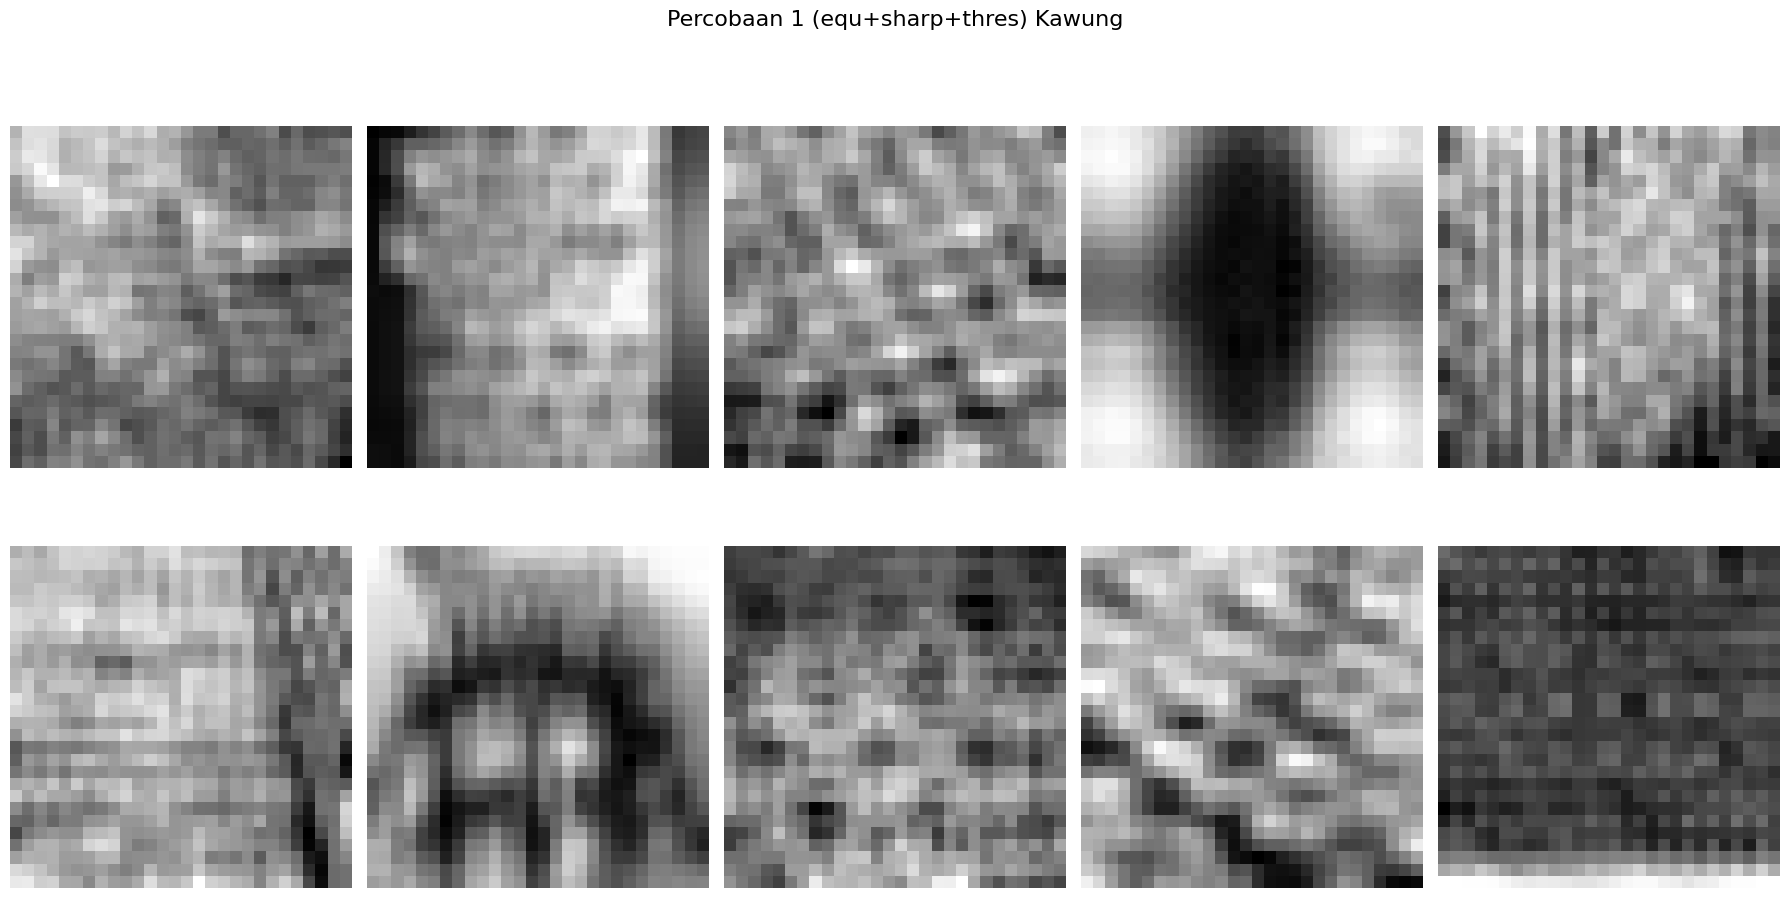

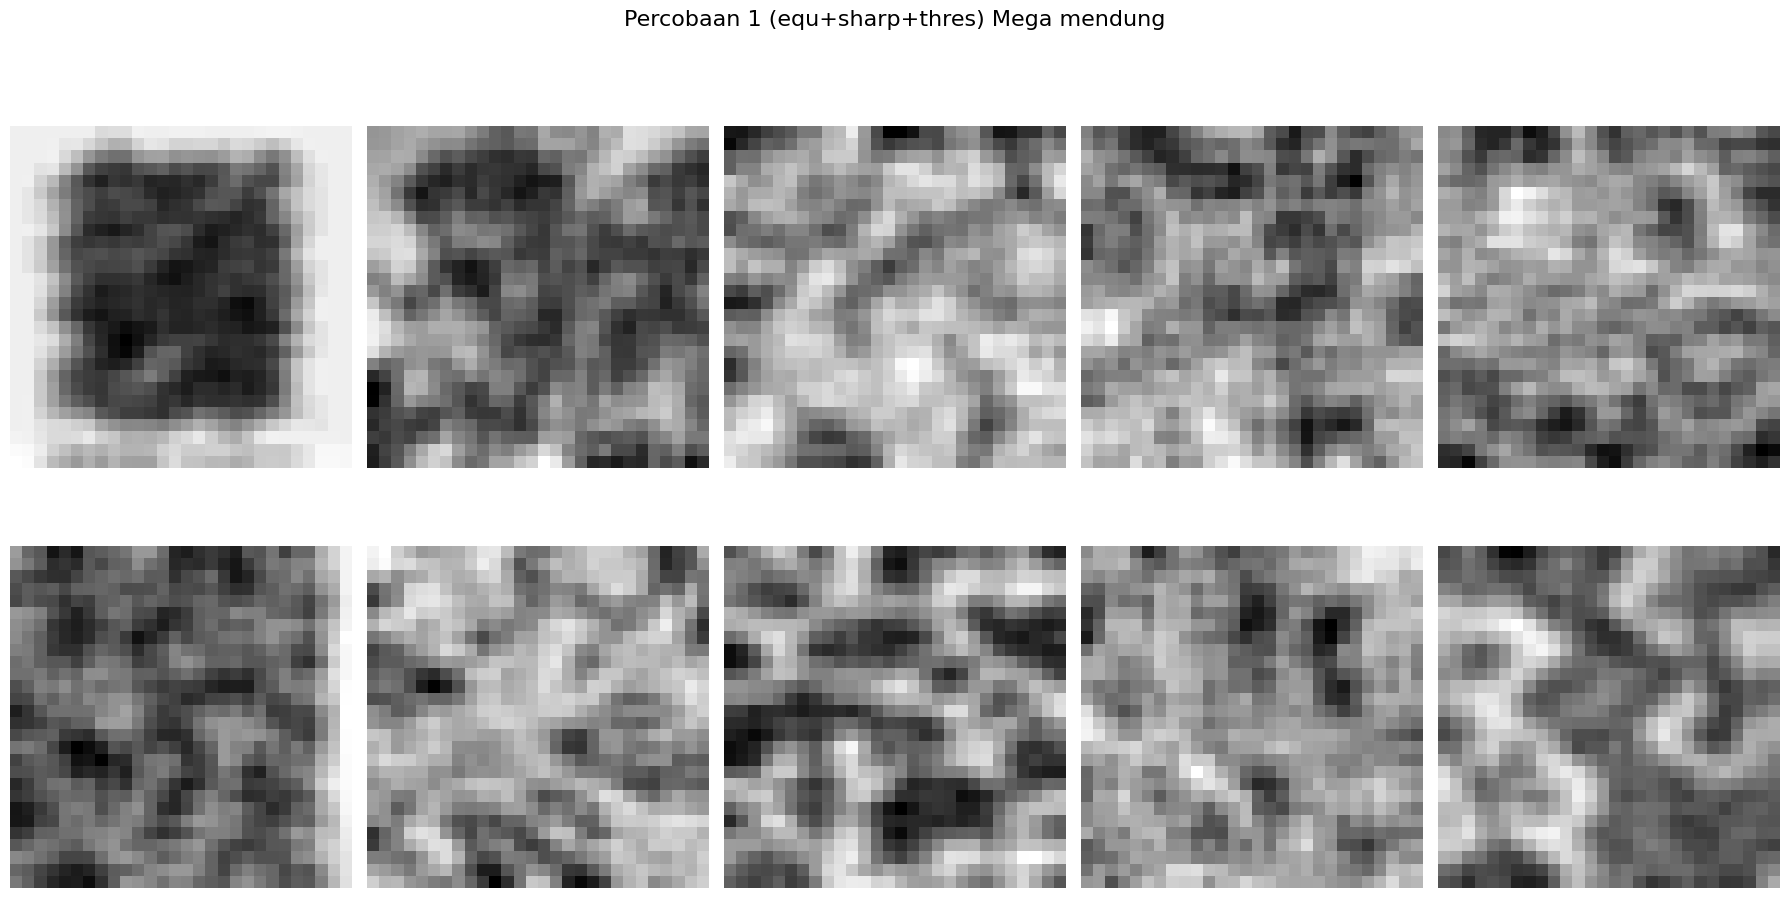

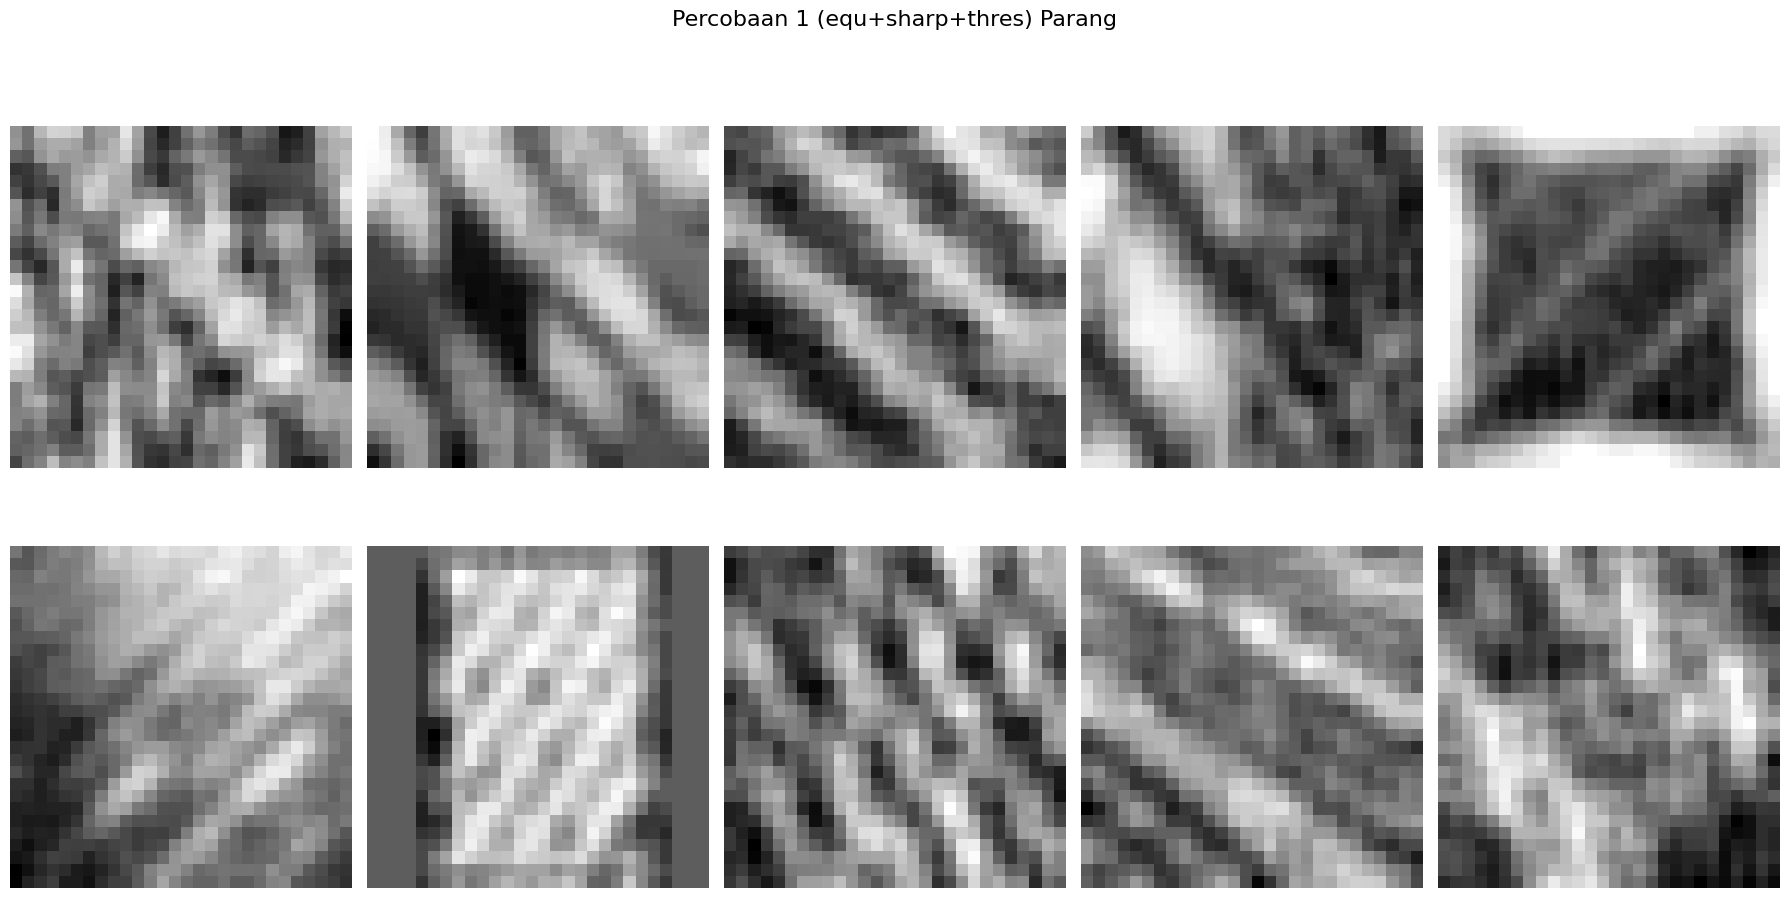

In [167]:
unique_labels = sorted(set(labels))

for label in unique_labels:
    # Ambil semua indeks gambar dari label ini
    idxs = [j for j, l in enumerate(labels) if l == label]
    
    # Buat grid 7x12 (cukup untuk 84 gambar, 7*12 = 84)
    fig, axs = plt.subplots(2, 5, figsize=(18, 10))
    fig.suptitle(f'Percobaan 1 (equ+sharp+thres) {label}', fontsize=16)
    
    for k in range(10):
        row = k // 5
        col = k % 5
        ax = axs[row][col]
        ax.imshow(dataPreprocessed[idxs[k]], cmap='gray')
        ax.axis('off')

    plt.tight_layout()

### Feature Extraction

In [168]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [169]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [170]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [171]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [172]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [173]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [174]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [175]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [176]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [177]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [178]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [179]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [180]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [181]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [182]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [183]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [184]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

In [185]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,kawung.10.jpg,Kawung,306.800265,529.290809,351.783069,571.190672,0.081158,0.068893,0.063039,0.048546,...,0.000821,0.000813,0.029280,0.028953,0.028646,0.028511,0.876582,0.784725,0.858727,0.766450
1,kawung.100.jpg,Kawung,528.306878,767.779150,270.978836,709.910837,0.061877,0.054577,0.117279,0.053525,...,0.000933,0.000821,0.028293,0.028379,0.030538,0.028659,0.902023,0.856271,0.952648,0.866831
2,kawung.101.jpg,Kawung,491.318783,915.060357,595.486772,953.524005,0.052433,0.042823,0.043998,0.033689,...,0.000795,0.000822,0.028524,0.028429,0.028200,0.028676,0.755336,0.537221,0.705170,0.520081
3,kawung.102.jpg,Kawung,278.711640,383.991770,130.174603,386.721536,0.083893,0.070748,0.104227,0.061271,...,0.000919,0.000834,0.028431,0.029196,0.030308,0.028872,0.970479,0.959055,0.986084,0.958754
4,kawung.103.jpg,Kawung,797.041005,867.994513,167.427249,857.329218,0.040642,0.039797,0.107674,0.032477,...,0.000958,0.000849,0.028707,0.029131,0.030951,0.029131,0.499743,0.427495,0.893669,0.433286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,parang.95.jpg,Parang,606.616402,742.458162,163.333333,725.775034,0.045199,0.040104,0.155227,0.035624,...,0.000953,0.000803,0.027950,0.027469,0.030866,0.028329,0.911520,0.892332,0.978170,0.894737
291,parang.96.jpg,Parang,666.437831,882.076818,388.978836,985.742112,0.045929,0.040376,0.057711,0.037633,...,0.000788,0.000784,0.027715,0.028246,0.028075,0.027995,0.702672,0.608315,0.831298,0.558903
292,parang.97.jpg,Parang,666.960317,428.086420,483.869048,1600.895748,0.052665,0.061928,0.047449,0.021216,...,0.000753,0.000733,0.027397,0.028179,0.027445,0.027072,0.859187,0.909338,0.899053,0.661783
293,parang.98.jpg,Parang,400.289683,1309.507545,724.115079,542.113855,0.068716,0.018362,0.033532,0.064848,...,0.000778,0.000870,0.029025,0.027742,0.027888,0.029500,0.811658,0.368623,0.669214,0.739356


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

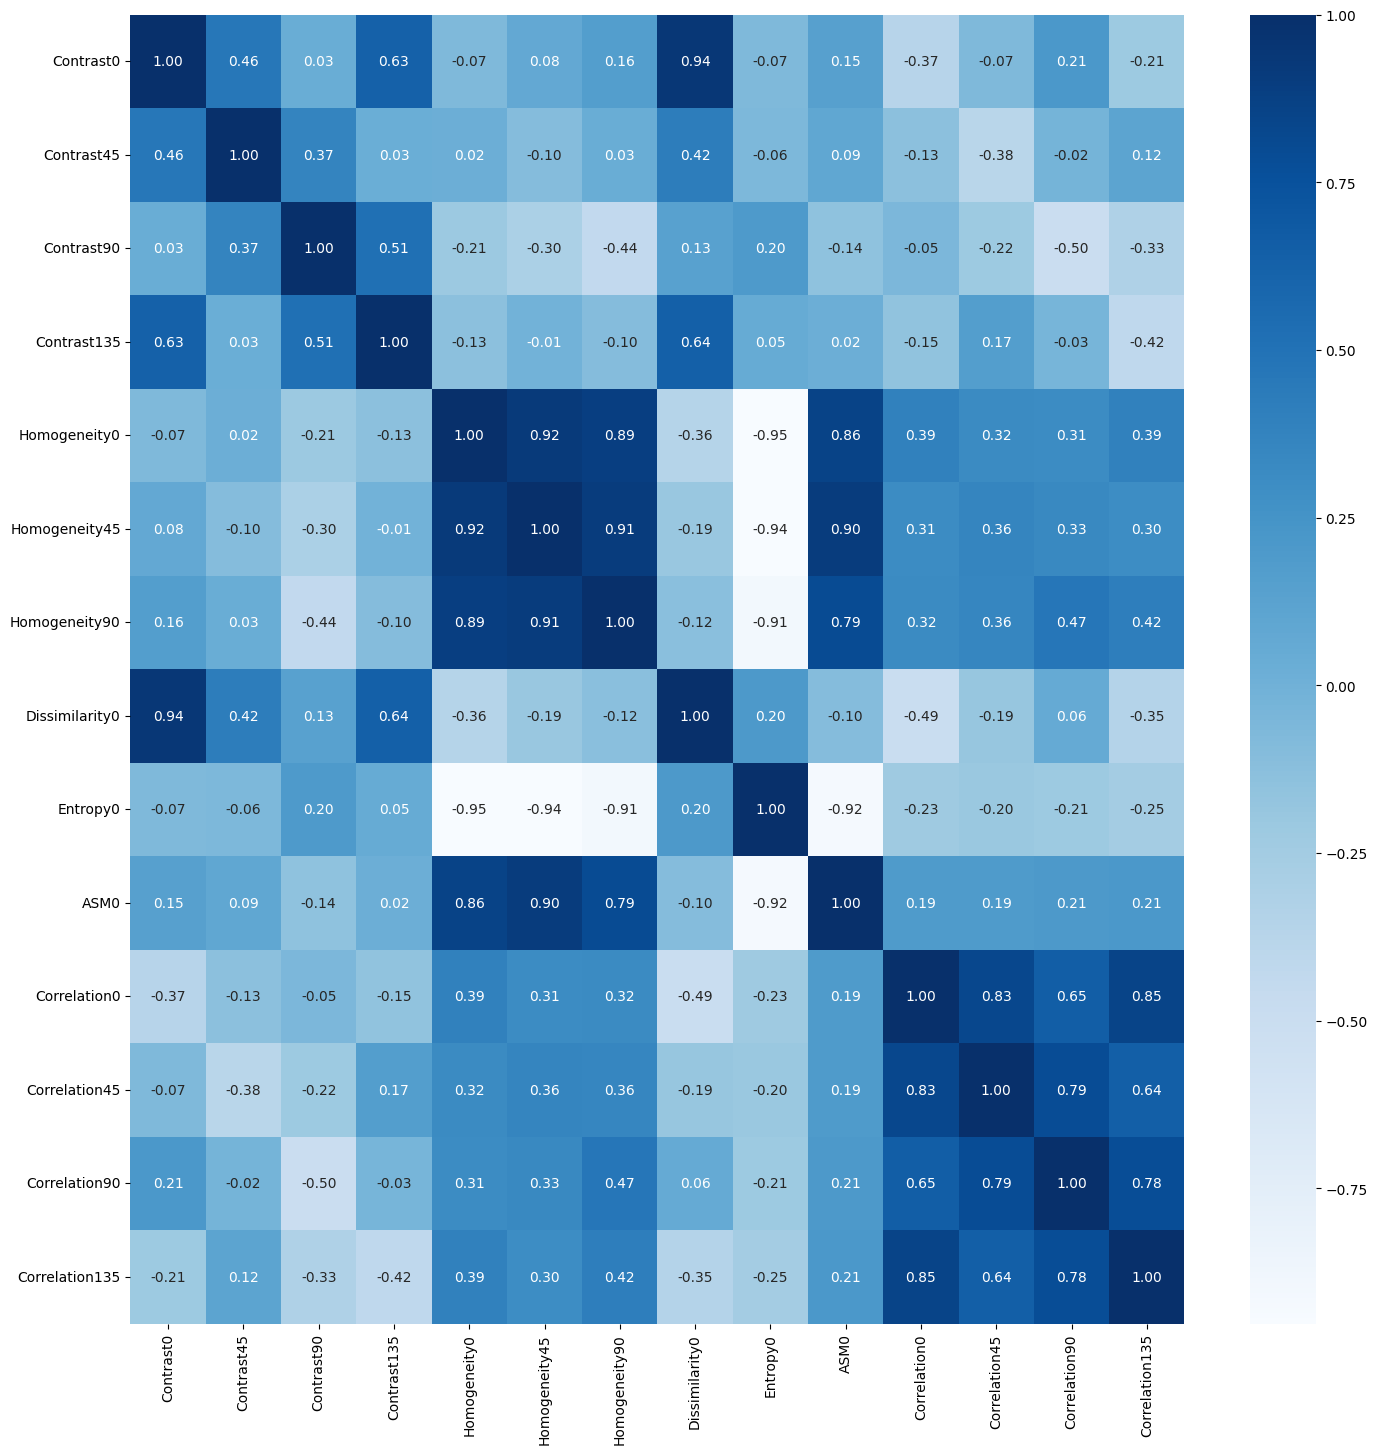

In [186]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [187]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(236, 14)
(59, 14)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [188]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [189]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [190]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

      Kawung       0.89      1.00      0.94        88
Mega mendung       0.94      0.87      0.90        54
      Parang       0.97      0.89      0.93        94

    accuracy                           0.93       236
   macro avg       0.93      0.92      0.92       236
weighted avg       0.93      0.93      0.93       236

[[88  0  0]
 [ 4 47  3]
 [ 7  3 84]]
Accuracy: 0.9279661016949152

------Testing Set------
              precision    recall  f1-score   support

      Kawung       0.43      0.50      0.47        20
Mega mendung       0.54      0.44      0.48        16
      Parang       0.70      0.70      0.70        23

    accuracy                           0.56        59
   macro avg       0.56      0.54      0.55        59
weighted avg       0.56      0.56      0.56        59

[[10  5  5]
 [ 7  7  2]
 [ 6  1 16]]
Accuracy: 0.559322033898305


### Train SVM Classifier

In [191]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

      Kawung       0.56      0.89      0.69        88
Mega mendung       0.82      0.17      0.28        54
      Parang       0.79      0.72      0.76        94

    accuracy                           0.66       236
   macro avg       0.72      0.59      0.57       236
weighted avg       0.71      0.66      0.62       236

[[78  1  9]
 [36  9  9]
 [25  1 68]]
Accuracy: 0.6567796610169492

------Testing Set------
              precision    recall  f1-score   support

      Kawung       0.50      0.75      0.60        20
Mega mendung       1.00      0.19      0.32        16
      Parang       0.65      0.74      0.69        23

    accuracy                           0.59        59
   macro avg       0.72      0.56      0.54        59
weighted avg       0.70      0.59      0.56        59

[[15  0  5]
 [ 9  3  4]
 [ 6  0 17]]
Accuracy: 0.5932203389830508


### Train KNN Classifier

In [192]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

      Kawung       0.64      0.85      0.73        88
Mega mendung       0.61      0.65      0.63        54
      Parang       0.93      0.61      0.74        94

    accuracy                           0.71       236
   macro avg       0.73      0.70      0.70       236
weighted avg       0.75      0.71      0.71       236

[[75 10  3]
 [18 35  1]
 [25 12 57]]
Accuracy: 0.7076271186440678

------Testing Set------
              precision    recall  f1-score   support

      Kawung       0.50      0.65      0.57        20
Mega mendung       0.53      0.62      0.57        16
      Parang       0.93      0.57      0.70        23

    accuracy                           0.61        59
   macro avg       0.65      0.61      0.61        59
weighted avg       0.67      0.61      0.62        59

[[13  6  1]
 [ 6 10  0]
 [ 7  3 13]]
Accuracy: 0.6101694915254238


## Evaluation With Confusion Matrix

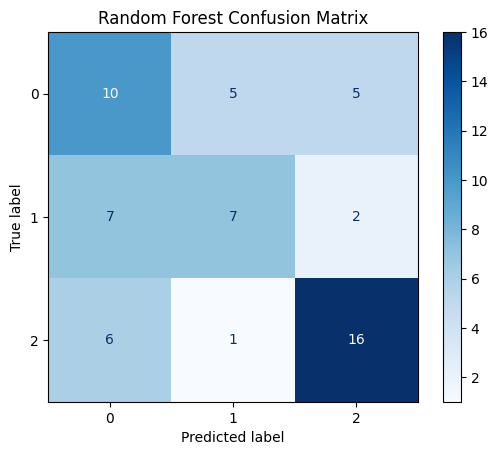

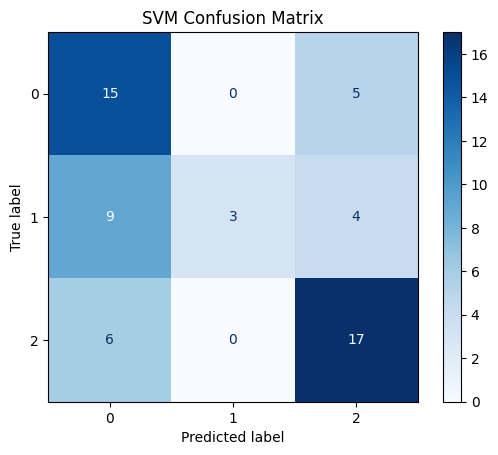

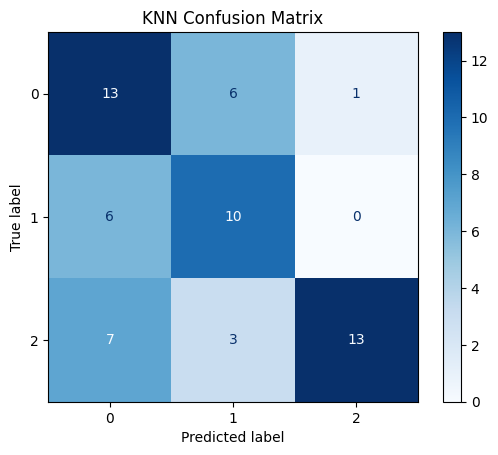

In [193]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")